# Forecasting solar flares using random forest
***


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [20]:
# Load raw dataframe
df = pd.read_csv("./Data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit random forest
***

In [21]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [22]:
# Analyze flare distribution over time

# Number of C, M, and X flares per year
sum_columns = ['Flares: M', 'Flares: X']
df_flares = df.groupby(df['DATE'].dt.year)[sum_columns].agg(['sum'])
#df_flares = df_flares.reset_index()
print(df_flares)

# Number of days with M or X flares
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with M or X flare distribution by year:")
print(yearly_flares)

     Flares: M Flares: X
           sum       sum
DATE                    
2010       8.0       0.0
2011     111.0       8.0
2012     129.0       7.0
2013      99.0      12.0
2014     208.0      16.0
2015     125.0       2.0
2016      16.0       0.0
2017      39.0       4.0
2018       0.0       0.0
2019       0.0       0.0
2020       2.0       0.0
2021      28.0       2.0
2022     184.0       7.0
2023      23.0       3.0

Days with M or X flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [23]:
# Function to create the lagged features to be used in the random forest model

def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict tomorrow's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame()
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: tomorrow's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [24]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 3 to 4478
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      4476 non-null   float64            
 1   MEANGAM_lag1                     4476 non-null   float64            
 2   MEANGBT_lag1                     4476 non-null   float64            
 3   MEANGBZ_lag1                     4476 non-null   float64            
 4   MEANGBH_lag1                     4476 non-null   float64            
 5   MEANJZD_lag1                     4476 non-null   float64            
 6   TOTUSJZ_lag1                     4476 non-null   float64            
 7   MEANALP_lag1                     4476 non-null   float64            
 8   MEANJZH_lag1                     4476 non-null   float64            
 9   TOTUSJH_lag1                     4476 non-null   float64            
 10  ABSNJ

In [25]:
# Separate features and target
X = lagged_data.drop(['target', 'DATE'], axis=1)
y = lagged_data['target']

In [26]:
# Split into train and test sets (chronological split is important for time series)
# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")



Training samples: 3580
Test samples: 896

Class distribution in training set:
target
0.0    3147
1.0     433
Name: count, dtype: int64
Percentage of positive cases in train: 12.09%

Class distribution in test set:
target
0.0    774
1.0    122
Name: count, dtype: int64
Percentage of positive cases in test: 13.62%


In [27]:
# Optional: Scale features (Random Forest doesn't require it, but doesn't hurt)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Apply SMOTE to balance the training data
print("\n" + "="*60)
print("APPLYING SMOTE TO BALANCE TRAINING DATA")
print("="*60)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {len(X_train_balanced)}")
print(pd.Series(y_train_balanced).value_counts())

# Hyperparameter tuning with GridSearchCV
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}


APPLYING SMOTE TO BALANCE TRAINING DATA

After SMOTE:
Training samples: 6294
target
1.0    3147
0.0    3147
Name: count, dtype: int64

HYPERPARAMETER TUNING


In [29]:
# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
# GridSearchCV with original imbalanced data (better for real-world evaluation)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search (this may take a while)...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")



Starting grid search (this may take a while)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation ROC-AUC: 0.8699


In [31]:
# Train final model with best parameters on balanced data
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train_balanced, y_train_balanced)


TRAINING FINAL MODEL


RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [32]:
# Make predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

In [33]:
# Evaluation
print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")



MODEL EVALUATION ON TEST SET

Confusion Matrix:
[[652 122]
 [ 54  68]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       774
         1.0       0.36      0.56      0.44       122

    accuracy                           0.80       896
   macro avg       0.64      0.70      0.66       896
weighted avg       0.85      0.80      0.82       896


ROC-AUC Score: 0.8172
Average Precision Score: 0.3952


In [34]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(30))


Top 20 Most Important Features:
                            feature  importance
27                   Flares: C_lag1    0.082843
22                   xrs_B_max_lag1    0.063467
19                   xrs_A_max_lag1    0.056159
20                  xrs_B_mean_lag1    0.048098
58                   Flares: C_lag2    0.043721
23           Radio Flux 10.7cm_lag1    0.039906
51                  xrs_B_mean_lag2    0.024703
85           Radio Flux 10.7cm_lag3    0.024597
53                   xrs_B_max_lag2    0.023891
54           Radio Flux 10.7cm_lag2    0.023122
21                   xrs_B_min_lag1    0.023122
17                  xrs_A_mean_lag1    0.022313
89                   Flares: C_lag3    0.022030
50                   xrs_A_max_lag2    0.020462
26                 New Regions_lag1    0.017192
83                   xrs_B_min_lag3    0.016952
52                   xrs_B_min_lag2    0.016652
84                   xrs_B_max_lag3    0.015519
24              Sunspot Number_lag1    0.014054
25  Sun


Visualization saved as 'solar_flare_RF_results.png'


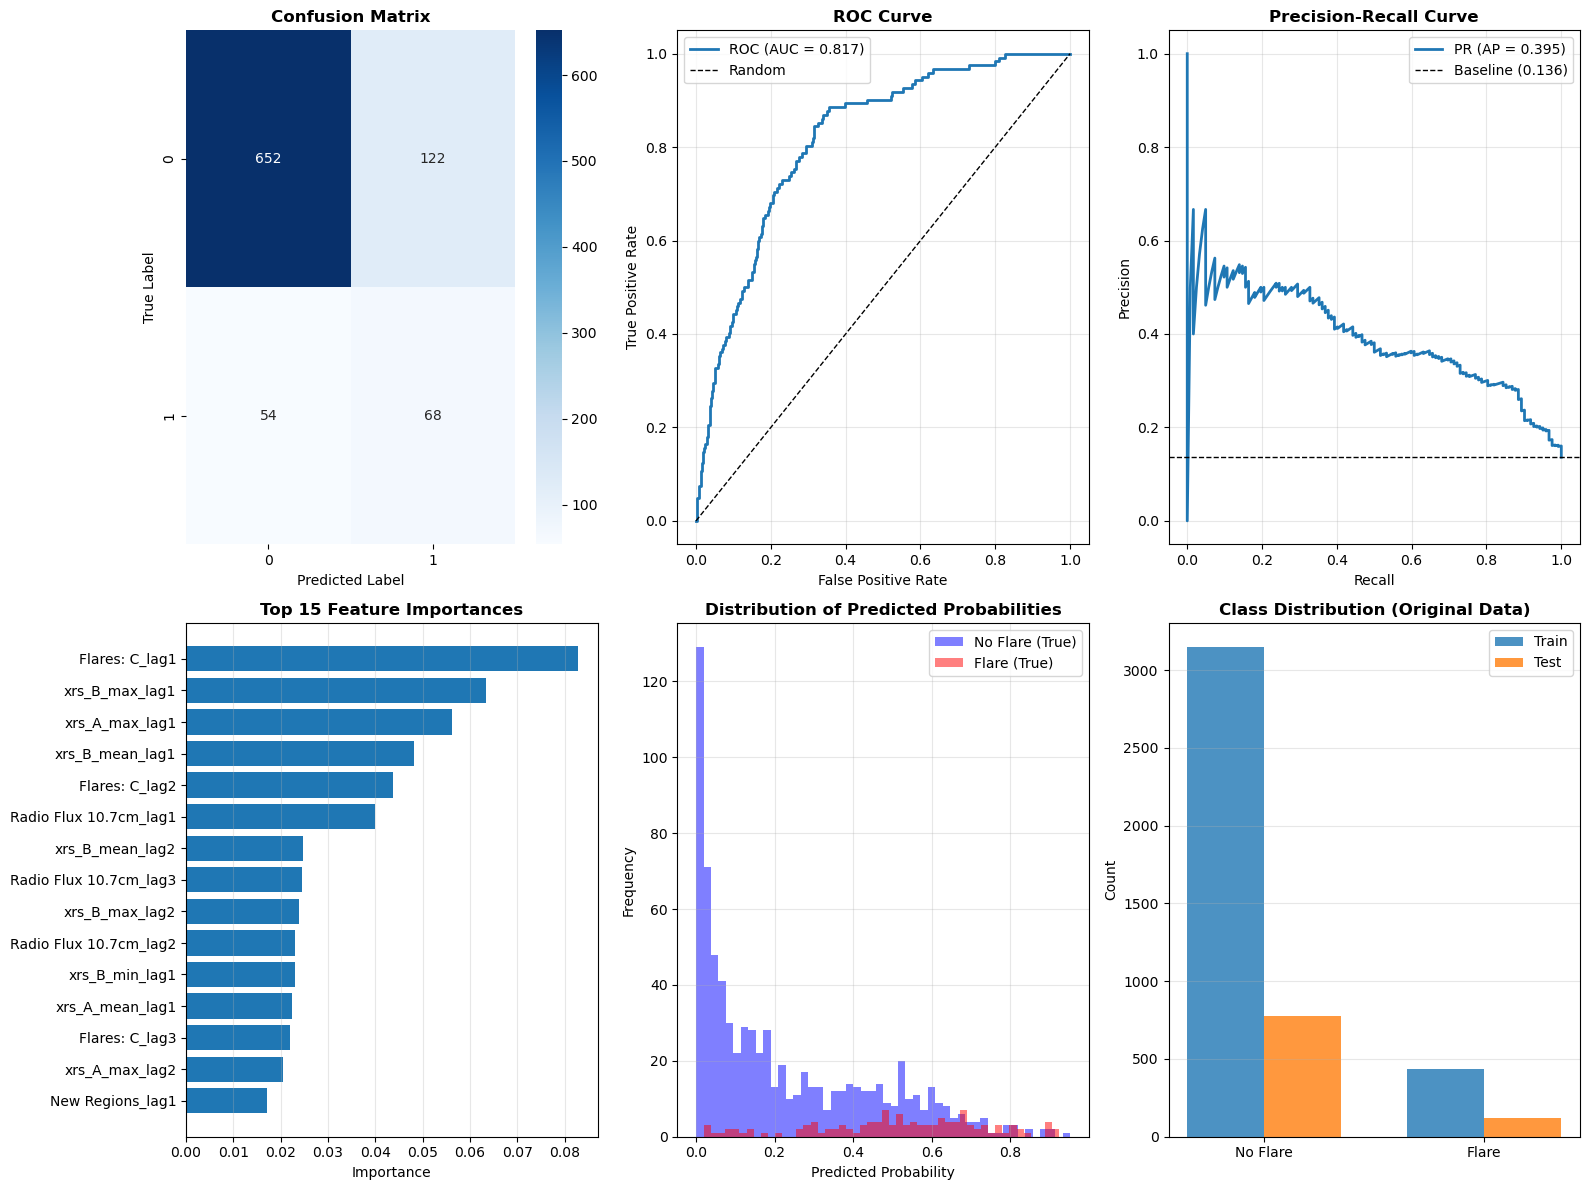

In [35]:
# plotting results

fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. ROC Curve
if len(np.unique(y_test)) > 1:
    ax2 = plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax3.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax3.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Top 15)
ax4 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(15)
ax4.barh(range(len(top_features)), top_features['importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.invert_yaxis()
ax4.set_xlabel('Importance')
ax4.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Prediction Probability Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax5.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Class Distribution
ax6 = plt.subplot(2, 3, 6)
train_dist = [sum(y_train == 0), sum(y_train == 1)]
test_dist = [sum(y_test == 0), sum(y_test == 1)]
x = np.arange(2)
width = 0.35
ax6.bar(x - width/2, train_dist, width, label='Train', alpha=0.8)
ax6.bar(x + width/2, test_dist, width, label='Test', alpha=0.8)
ax6.set_ylabel('Count')
ax6.set_title('Class Distribution (Original Data)', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(['No Flare', 'Flare'])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./Figures/solar_flare_RF_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_RF_results.png'")
plt.show()

In [36]:
print("\n" + "="*60)
print("THRESHOLD ANALYSIS")
print("="*60)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


THRESHOLD ANALYSIS

Threshold = 0.3
  TP: 102, FP: 244, TN: 530, FN: 20
  Precision: 0.295, Recall: 0.836

Threshold = 0.4
  TP: 89, FP: 184, TN: 590, FN: 33
  Precision: 0.326, Recall: 0.730

Threshold = 0.5
  TP: 68, FP: 122, TN: 652, FN: 54
  Precision: 0.358, Recall: 0.557

Threshold = 0.6
  TP: 48, FP: 63, TN: 711, FN: 74
  Precision: 0.432, Recall: 0.393

Threshold = 0.7
  TP: 25, FP: 25, TN: 749, FN: 97
  Precision: 0.500, Recall: 0.205
